In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math, re, os

print(tf.__version__)

2022-06-09 05:36:27.991607: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-09 05:36:27.991731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.4.1


Reference for importing data: https://www.kaggle.com/code/ryanholbrook/create-your-first-submission/notebook

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-06-09 05:36:33.581909: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-09 05:36:33.584724: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-09 05:36:33.584762: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 05:36:33.584788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c0e0dab346ca): /proc/driver/nvidia/version does not exist
2022-06-09 05:36:33.587810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-02d8028567fea25689490b7b16d8093b0a671809699cf11da3dda3fc


In [4]:
IMAGE_SIZE = [192, 192]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

2022-06-09 05:36:39.854029: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-09 05:36:39.939204: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-09 05:36:40.013390: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [36]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_training_dataset_preview(ordered=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print('Batch Size: ', BATCH_SIZE)

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Batch Size:  128
Training: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.string)>


In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [69 88 78 ... 74 70  4]


2022-06-09 05:36:42.960587: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654753002.956298813","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 0","grpc_status":3}


In [10]:
sample_batch_size = 16

def create_batch(ds):
    ds_iter = iter(ds.unbatch().batch(sample_batch_size))
    return next(ds_iter)    

def batch_to_images(ds_batch):
    images, labels = ds_batch
    return images.numpy(), labels.numpy()

def show_batch(ds):
    sample_batch = create_batch(ds)
    images, labels = batch_to_images(sample_batch)
    ncols = math.floor((math.sqrt(len(labels))))
    nrows = len(labels) // ncols
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 9))
    for ax, image, label in zip(axs.flatten(), images, labels):
        ax.imshow(image)
        ax.set_title(CLASSES[label])
        ax.axis('off')

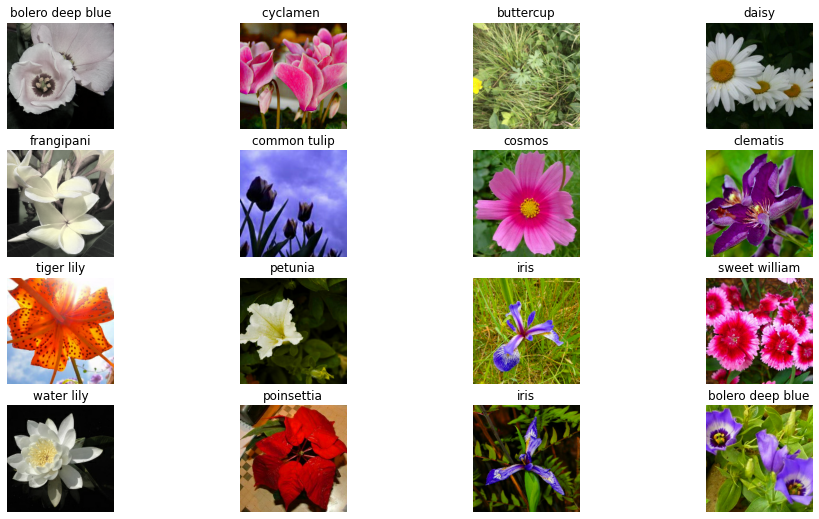

In [11]:
show_batch(ds_train)

In [12]:
def ds_to_labels(ds, num_images):
    return next(iter(ds.unbatch().map(lambda image, label: label).batch(num_images))).numpy()

def plot_class_dist(ds, num_images):
    labels = ds_to_labels(ds, num_images)
    names = map(lambda x: CLASSES[x], labels)
    names_df = pd.DataFrame(names)
    names_df.value_counts().plot.barh(figsize=(15,20))

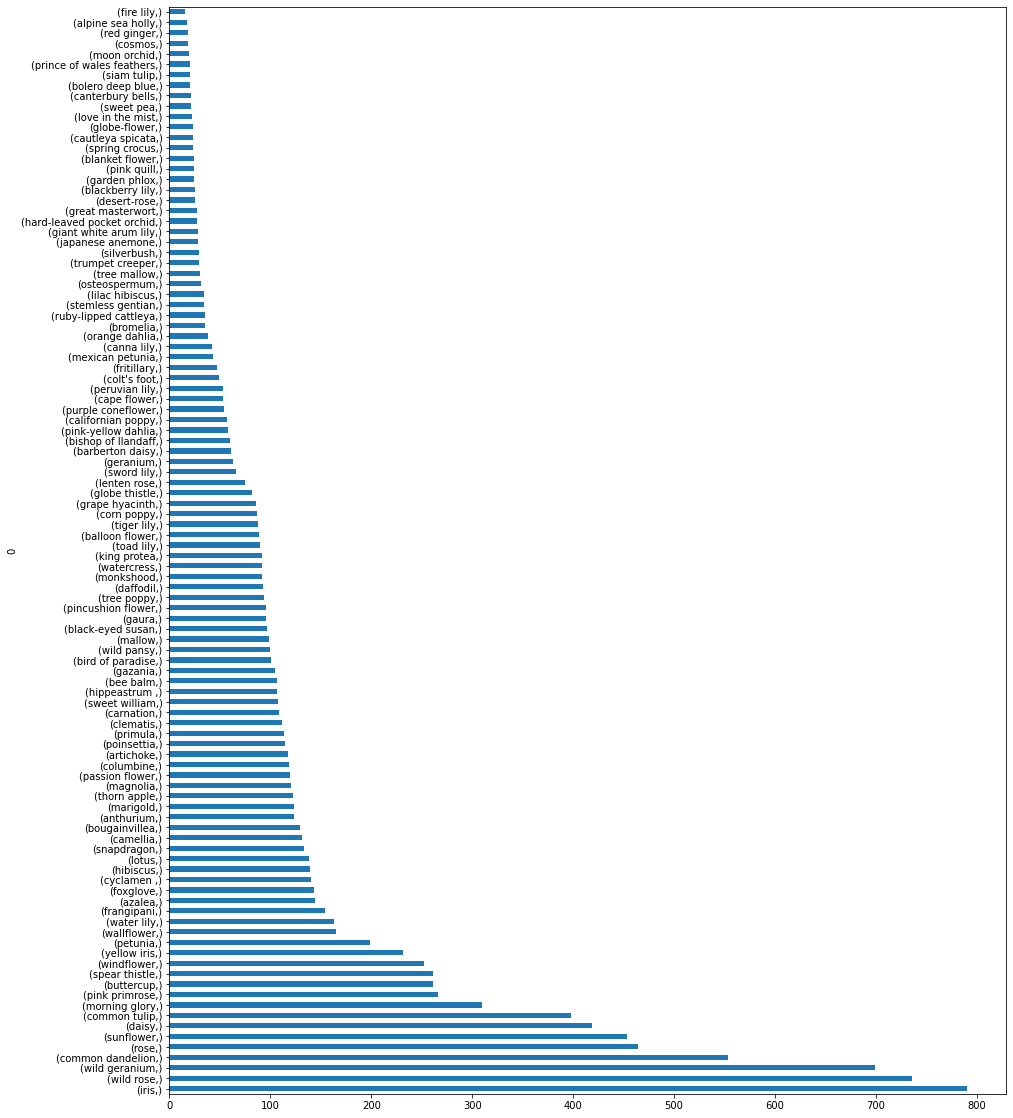

In [13]:
plot_class_dist(ds_train, NUM_TRAINING_IMAGES)

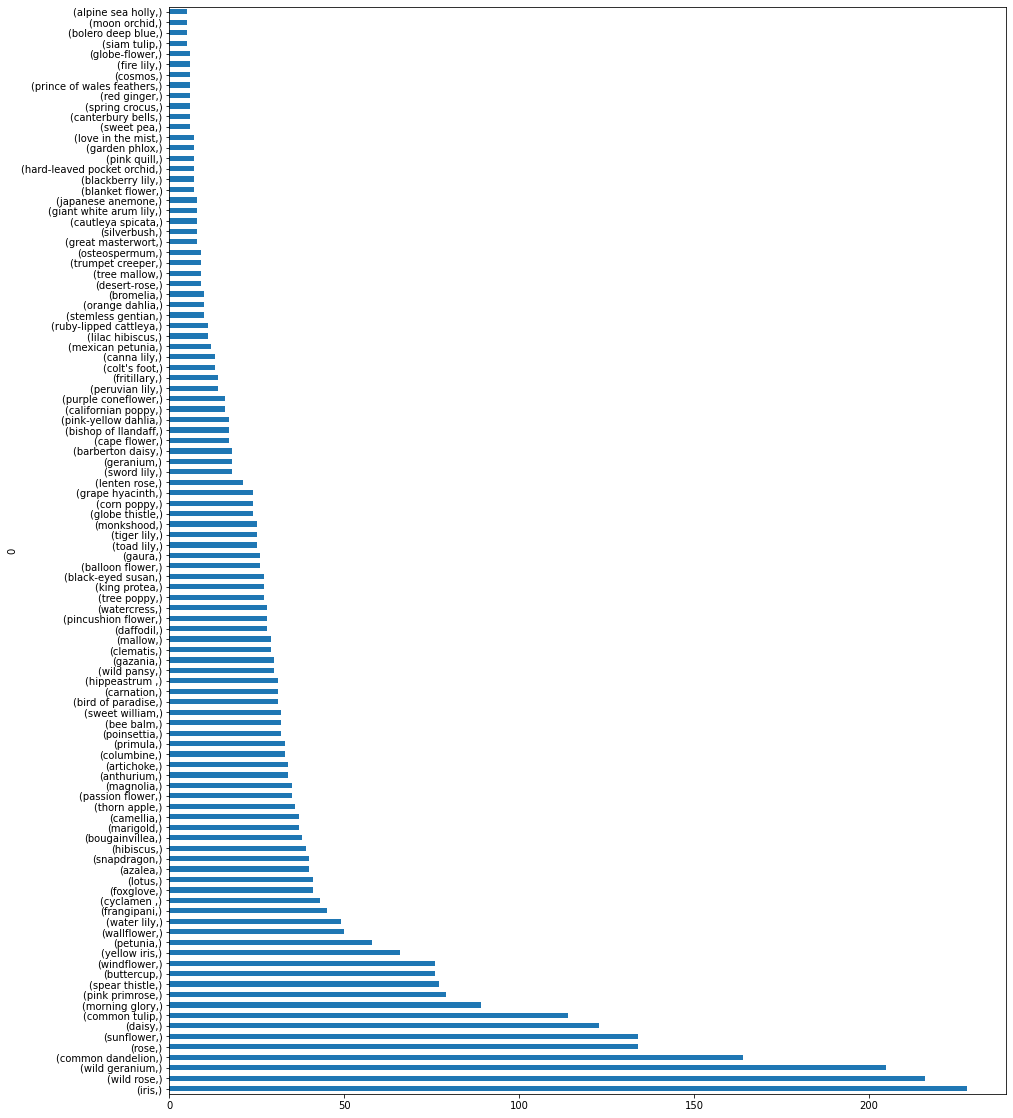

In [14]:
plot_class_dist(ds_valid, NUM_VALIDATION_IMAGES)

In [15]:
class FlowerClassifier(tf.keras.Model):
    def __init__(self, input_shape, n_classes):
        super().__init__(self)
        self.input_layer = tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape)
        self.conv1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')
        self.max_pool = tf.keras.layers.MaxPooling2D(2,2)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
        
    def call(self, input):
        x = self.input_layer(input)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [35]:
for image, label in ds_train.take(1):
    image = image.numpy()
    BATCH_SIZE = image.shape[0]
    DIM_X = image.shape[1]
    DIM_Y = image.shape[2]
    DIM_CH = image.shape[3]

INPUT_SHAPE = [DIM_X, DIM_Y, DIM_CH]

ds_train = get_training_dataset_preview()
labels = ds_to_labels(ds_train, NUM_TRAINING_IMAGES)

N_CLASSES = len(set(labels))

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('INPUT_SHAPE: {}, N_CLASSES: {}, STEPS_PER_EPOCH: {}'.format(INPUT_SHAPE, N_CLASSES, STEPS_PER_EPOCH))

2022-06-09 05:56:22.890103: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 43099, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654754182.890025862","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 43099, Output num: 0","grpc_status":3}


INPUT_SHAPE: [192, 192, 3], N_CLASSES: 104, STEPS_PER_EPOCH: 99


In [17]:
tf.keras.backend.clear_session()

with strategy.scope():
    model = FlowerClassifier(INPUT_SHAPE, N_CLASSES)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
EPOCHS = 35
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch/35))

history = model.fit(
    x = get_training_dataset(),
    validation_data = get_validation_dataset(),
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks=[lr_schedule]
)

Epoch 1/35
99/99 [==============================] - 18s 103ms/step - loss: 4.5142 - accuracy: 0.0465 - val_loss: 4.2992 - val_accuracy: 0.1094
Epoch 2/35
99/99 [==============================] - 6s 56ms/step - loss: 4.2097 - accuracy: 0.0804 - val_loss: 4.0931 - val_accuracy: 0.1226
Epoch 3/35
99/99 [==============================] - 6s 56ms/step - loss: 4.0201 - accuracy: 0.1036 - val_loss: 3.9318 - val_accuracy: 0.1390
Epoch 4/35
99/99 [==============================] - 6s 56ms/step - loss: 3.8711 - accuracy: 0.1200 - val_loss: 3.8363 - val_accuracy: 0.1579
Epoch 5/35
99/99 [==============================] - 6s 56ms/step - loss: 3.7585 - accuracy: 0.1339 - val_loss: 3.6324 - val_accuracy: 0.1759
Epoch 6/35
99/99 [==============================] - 6s 56ms/step - loss: 3.6642 - accuracy: 0.1422 - val_loss: 3.5684 - val_accuracy: 0.1934
Epoch 7/35
99/99 [==============================] - 6s 56ms/step - loss: 3.6029 - accuracy: 0.1499 - val_loss: 3.5209 - val_accuracy: 0.2031
Epoch 8/35


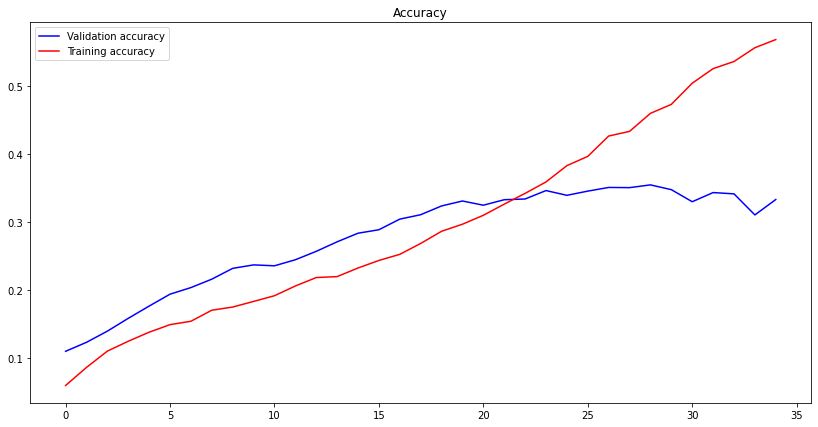

In [19]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))
plt.subplots(figsize=(14,7))
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Accuracy')
plt.legend(loc=0)
plt.show()

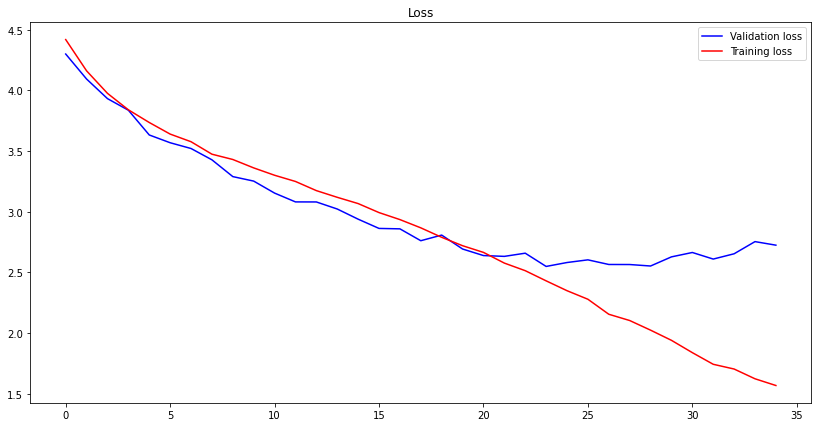

In [20]:
plt.subplots(figsize=(14,7))
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Loss')
plt.legend(loc=0)
plt.show()

In [37]:
ds_train = get_training_dataset_preview(ordered=True)
ds_valid = get_validation_dataset(ordered=True)

x_train = ds_train.map(lambda image, label: image)
x_valid = ds_valid.map(lambda image, label: image)

train_preds = model.predict(x_train)
train_preds = np.argmax(train_preds, axis=-1)

valid_preds = model.predict(x_valid)
valid_preds = np.argmax(valid_preds, axis=-1)

y_train = ds_to_labels(ds_train, NUM_TRAINING_IMAGES)
y_valid = ds_to_labels(ds_valid, NUM_VALIDATION_IMAGES)

2022-06-09 05:58:43.651780: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 43532, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654754323.651607856","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 43532, Output num: 0","grpc_status":3}


In [38]:
from sklearn.metrics import classification_report

print('VALIDATION SET REPORT:\n', classification_report(y_valid, valid_preds, target_names=CLASSES))
print('TRAINING SET REPORT:\n', classification_report(y_train, train_preds, target_names=CLASSES))

VALIDATION SET REPORT:
                            precision    recall  f1-score   support

            pink primrose       0.37      0.32      0.34        79
hard-leaved pocket orchid       1.00      0.43      0.60         7
         canterbury bells       0.00      0.00      0.00         6
                sweet pea       0.00      0.00      0.00         6
            wild geranium       0.42      0.52      0.46       205
               tiger lily       0.17      0.32      0.22        25
              moon orchid       0.00      0.00      0.00         5
         bird of paradise       0.46      0.39      0.42        31
                monkshood       0.25      0.12      0.16        25
            globe thistle       0.41      0.71      0.52        24
               snapdragon       0.00      0.00      0.00        40
              colt's foot       0.33      0.08      0.12        13
              king protea       0.61      0.41      0.49        27
            spear thistle       0.35 